---
## Data Prep

### Dataset Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from time import time
from src.features import build_features as bf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline

sns.set()

---
## Data Preprocessing

In [2]:
features_raw = pd.read_csv('../data/interim/features_raw.csv', index_col='Id')
target = pd.read_csv('../data/interim/target_raw.csv', index_col='Id', squeeze=True)

In [3]:
features_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
features_raw.shape

(1460, 79)

In [5]:
df_zscore = pd.read_csv('../data/interim/df_zscore.csv', index_col='Id')
outlier_idx = df_zscore[(df_zscore >= 5).any(1)].index
outlier_idx

Int64Index([497, 524, 692, 1183, 1299], dtype='int64', name='Id')

### Handle Outliers

In [31]:
df = features_raw.drop(index=outlier_idx)
target = target.drop(index=outlier_idx)
index = df.index

# Uncomment this line to save the DataFrames
# target.to_csv('../data/interim/target_no_outliers.csv')

KeyError: '[ 497  524  692 1183 1299] not found in axis'

In [7]:
df.shape

(1455, 79)

### Assess Missing Data

#### Assess Missing Data in Each Column

In [8]:
df.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1450
MiscFeature     1401
Alley           1364
Fence           1175
FireplaceQu      690
LotFrontage      258
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

#### Assess Missing Data in Each Column

In [9]:
nan_count = df.isna().sum()
nan_count = nan_count[nan_count > 0]
nan_cols = df[nan_count.index].columns
(nan_count / df.shape[0]).sort_values(ascending=False)

PoolQC          0.996564
MiscFeature     0.962887
Alley           0.937457
Fence           0.807560
FireplaceQu     0.474227
LotFrontage     0.177320
GarageYrBlt     0.055670
GarageType      0.055670
GarageFinish    0.055670
GarageQual      0.055670
GarageCond      0.055670
BsmtFinType2    0.026117
BsmtExposure    0.026117
BsmtFinType1    0.025430
BsmtCond        0.025430
BsmtQual        0.025430
MasVnrArea      0.005498
MasVnrType      0.005498
Electrical      0.000687
dtype: float64

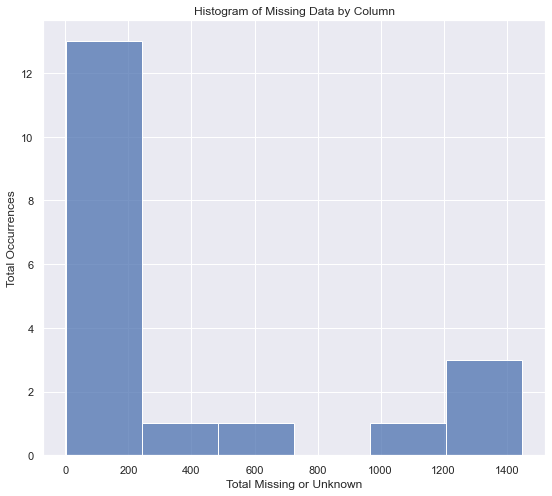

<Figure size 432x288 with 0 Axes>

In [10]:
# Investigate patterns in the amount of missing data in each column.

# plt.rcParams.update({'figure.dpi':100})

plt.figure(figsize=(9, 8))
ax = sns.histplot(nan_count, kde=False)
ax.set_title('Histogram of Missing Data by Column')
ax.set(xlabel='Total Missing or Unknown', ylabel='Total Occurrences')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/MissingDatabyCol_Histogram.svg')

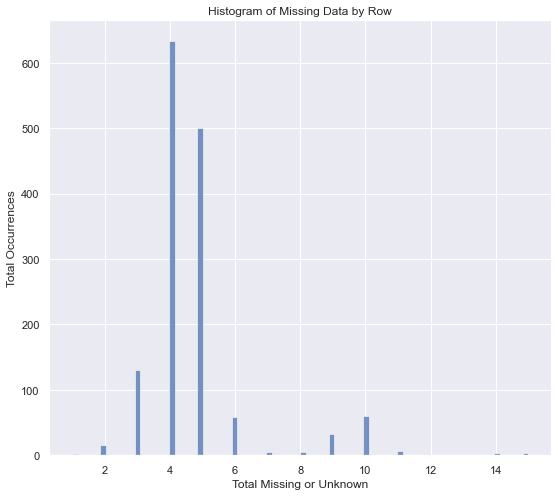

<Figure size 432x288 with 0 Axes>

In [11]:
nan_rows = df.isna().sum(axis=1)
plt.figure(figsize=(9, 8))
ax = sns.histplot(nan_rows, kde=False)
ax.set_title('Histogram of Missing Data by Row')
ax.set(xlabel='Total Missing or Unknown', ylabel='Total Occurrences')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/MissingDatabyRow_Histogram.svg')

#### Assessment Summary

There is a fair amount of missing data in this dataset. Four features in particular (PoolQC, MiscFeature, Alley, Fence) contain >50% missing or unknown values. For PoolQC, we may be able to imply whether or not the home has a pool performing some feature engineering on the PoolArea feature. In addition, several features such as 'GarageArea' indicate the total square footage of a garage (if any) but our dataset does not seem to indicate whether a not a particular home has a garage or not. We'll create features for these. Let's investigate these in turn.

In [12]:
df['PoolArea'].value_counts()

0      1450
738       1
648       1
576       1
519       1
512       1
Name: PoolArea, dtype: int64

Most homes don't have pools. Let's use the value of 'PoolArea' to assign 'NA' to 'PoolQC' if the area == 0

In [13]:
df['PoolQC'].value_counts()

Gd    2
Fa    2
Ex    1
Name: PoolQC, dtype: int64

In [14]:
df.loc[df['PoolArea'] == 0, 'PoolQC'] = 'NA' # If no 'PoolArea', (0), then there is no pool 
df['PoolQC'].value_counts()

NA    1450
Gd       2
Fa       2
Ex       1
Name: PoolQC, dtype: int64

Similarly, let's apply the same logic to other features where necessary:

In [15]:
df['Fence'].value_counts()

MnPrv    156
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [16]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [17]:
df['BsmtCond'].value_counts()

TA    1306
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [18]:
df['FireplaceQu'].value_counts()

Gd    377
TA    312
Fa     33
Ex     23
Po     20
Name: FireplaceQu, dtype: int64

In [19]:
df.loc[df['Fence'].isna(), 'Fence'] = 'NA'
df.loc[df['Alley'].isna(), 'Alley'] = 'NA'
df.loc[df['BsmtQual'].isna(), 'BsmtQual'] = 'NA'
df.loc[df['BsmtCond'].isna(), 'Bsmtcond'] = 'NA'
df.loc[df['BsmtExposure'].isna(), 'BsmtExposure'] = 'NA'
df.loc[df['BsmtFinType1'].isna(), 'BsmtFinType1'] = 'NA'
df.loc[df['BsmtFinType2'].isna(), 'BsmtFinType2'] = 'NA'
df.loc[df['FireplaceQu'].isna(), 'FireplaceQu'] = 'NA'

df['HasFence'] = df['Fence']
df['HasFence'].apply(lambda x: 1 if x != 'NA' else 0)

df['HasAlley'] = df['Alley']
df['HasAlley'].apply(lambda x: 1 if x != 'NA' else 0)

df['HasPool'] = df['PoolArea']
df['HasPool'].apply(lambda x: 1 if x > 0 else 0)

df['HasGarage'] = df['GarageArea']
df['HasGarage'].apply(lambda x: 1 if x > 0 else 0)

df['HasBasement'] = df['TotalBsmtSF']
df['HasBasement'].apply(lambda x: 1 if x > 0 else 0)

df['HasFireplace'] = df['FireplaceQu']
df['HasFireplace'].apply(lambda x: 1 if x != 'NA' else 0)

Id
1       0
2       1
3       1
4       1
5       1
       ..
1456    1
1457    1
1458    1
1459    0
1460    0
Name: HasFireplace, Length: 1455, dtype: int64

In [20]:
categorical_cols = df.select_dtypes(include=object).columns
numerical_cols = df.select_dtypes(include=np.number).columns

In [21]:
# Perform One-Hot Encoding on our Categorical Data

features_enc = df.copy()
onehot_df = features_enc.drop(columns=categorical_cols)
features_onehot_enc = pd.get_dummies(features_enc[categorical_cols], dummy_na=True)
onehot_df[features_onehot_enc.columns] = features_onehot_enc

# Uncomment this line to export DataFrame
# onehot_df.to_csv('../data/interim/onehot_df.csv')

# Print the number of features after one-hot encoding
encoded = list(onehot_df.columns)
print(f'{len(encoded)} total features after one-hot encoding.')

# Uncomment the following line to see the encoded feature names
# print(encoded)

360 total features after one-hot encoding.


In [22]:
onehot_df.isna().sum().sort_values().tail(3)

MasVnrArea       8
GarageYrBlt     81
LotFrontage    258
dtype: int64

In [23]:
nan_labels = ['MasVnrArea_nan', 'GarageYrBlt_nan', 'LotFrontage_nan']
encoded.extend(nan_labels)

In [24]:
imp = IterativeImputer(missing_values=np.nan, random_state=5, max_iter=20, add_indicator=True)
imputed_arr = imp.fit_transform(onehot_df)
features_imputed = pd.DataFrame(imputed_arr, columns=encoded)
features_imputed.index = onehot_df.index

# Uncomment this line to export DataFrame
# features_imputed.to_csv('../data/interim/features_imputed.csv')

### Feature Transformation
#### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. We'll need to check the following continuous data features for 'skew'.

- LotFrontage
- LotArea
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- LowQualFinSF
- GrLivArea
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal

In [25]:
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

skew = features_imputed[continuous_cols].skew().sort_index()
skew

1stFlrSF          0.782029
2ndFlrSF          0.776812
3SsnPorch        10.286243
BsmtFinSF1        0.746698
BsmtFinSF2        4.246917
EnclosedPorch     3.095410
GarageArea        0.133657
GrLivArea         0.823556
LotArea          12.584380
LotFrontage       1.374661
LowQualFinSF      8.995367
MasVnrArea        2.644332
MiscVal          24.435000
OpenPorchSF       2.340362
PoolArea         17.516549
ScreenPorch       4.113996
TotalBsmtSF       0.410688
WoodDeckSF        1.554775
dtype: float64

In [26]:
# Show columns with skew greater than 2 * Standard Error
skew > 2 * features_imputed[continuous_cols].sem().sort_index()

1stFlrSF         False
2ndFlrSF         False
3SsnPorch         True
BsmtFinSF1       False
BsmtFinSF2       False
EnclosedPorch    False
GarageArea       False
GrLivArea        False
LotArea          False
LotFrontage       True
LowQualFinSF      True
MasVnrArea       False
MiscVal          False
OpenPorchSF      False
PoolArea          True
ScreenPorch       True
TotalBsmtSF      False
WoodDeckSF       False
dtype: bool

/Users/seanward/anaconda3/envs/HousingEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


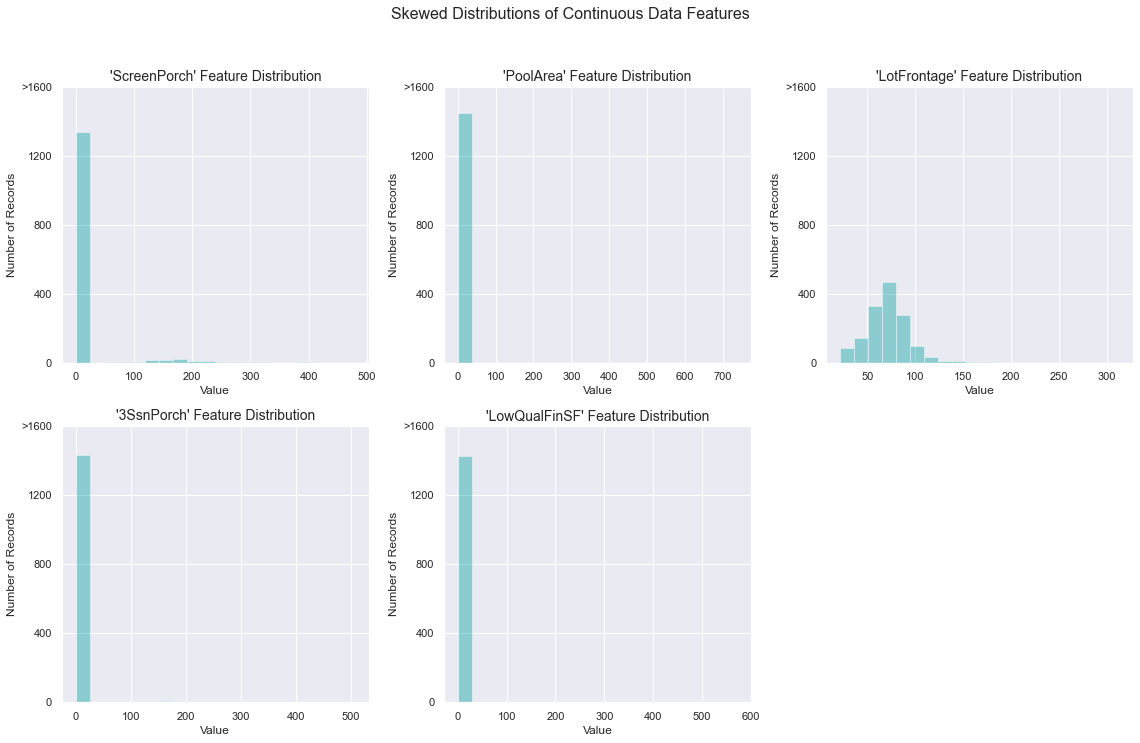

In [27]:
skewed = ['ScreenPorch', 'PoolArea', 'LotFrontage', '3SsnPorch', 'LowQualFinSF']

fig = plt.figure(figsize = (16,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    sns.distplot(features_imputed[feature], kde=False, bins=20, color='#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 1600))
    ax.set_yticks([0, 400, 800, 1200, 1600])
    ax.set_yticklabels([0, 400, 800, 1200, ">1600"])

# Plot aesthetics
fig.suptitle("Skewed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Skewed_Distributions.svg')

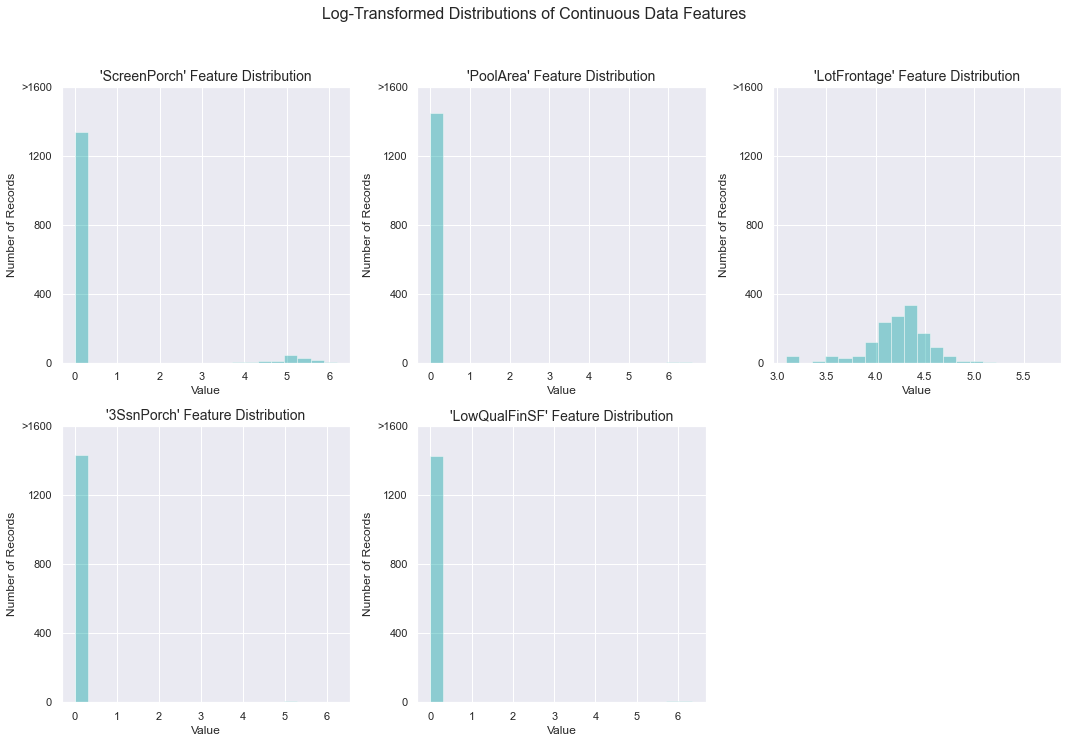

In [28]:
features_log_xformed = pd.DataFrame(data = features_imputed)
features_log_xformed[skewed] = features_imputed[skewed].apply(lambda x: np.log(x + 1))

fig = plt.figure(figsize = (15,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    sns.distplot(features_log_xformed[feature], kde=False, bins=20, color='#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 1600))
    ax.set_yticks([0, 400, 800, 1200, 1600])
    ax.set_yticklabels([0, 400, 800, 1200, ">1600"])

# Plot aesthetics
fig.suptitle("Log-Transformed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Log_Xformed_Distributions.svg')

We also need to look at our target variable 'SalePrice' and perform a log-transformation on it to remove skew.

### Feature Scaling
#### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. Normalization does, however,  ensure that each feature is treated equally when applying supervised learners.

In [29]:
# Initialize scaler, then apply it to the features
scaler = StandardScaler()
numerical = features_log_xformed.select_dtypes(include=np.number).columns

features_scaled = pd.DataFrame(data = features_log_xformed)
features_scaled[numerical] = scaler.fit_transform(features_log_xformed[numerical])

features_final = features_scaled.copy()

# Uncomment this line to export DataFrame
# features_scaled.to_csv('../data/interim/features_scaled.csv')

# Uncomment this line to export DataFrame
# features_final.to_csv('../data/processed/features_final.csv')

# Show an example of a record with scaling applied
features_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,HasFireplace_Ex,HasFireplace_Fa,HasFireplace_Gd,HasFireplace_NA,HasFireplace_Po,HasFireplace_TA,HasFireplace_nan,MasVnrArea_nan,GarageYrBlt_nan,LotFrontage_nan
Id,,,,,,,,,,,,,,,,,,,,,
1,0.072871,-0.086280,-0.202548,0.666823,-0.517687,1.054053,0.880646,0.528207,0.627235,-0.28919,...,-0.126734,-0.152338,-0.591373,1.052946,-0.118056,-0.522461,0.0,-0.464262,-0.074355,-0.2428
2,-0.871698,0.530546,-0.085922,-0.063770,2.175642,0.159914,-0.426795,-0.579375,1.260159,-0.28919,...,-0.126734,-0.152338,-0.591373,-0.949716,-0.118056,1.914017,0.0,-0.464262,-0.074355,-0.2428
3,0.072871,0.047605,0.081411,0.666823,-0.517687,0.987820,0.832223,0.336075,0.115310,-0.28919,...,-0.126734,-0.152338,-0.591373,-0.949716,-0.118056,1.914017,0.0,-0.464262,-0.074355,-0.2428
4,0.309014,-0.323562,-0.090993,0.666823,-0.517687,-1.860177,-0.717337,-0.579375,-0.512961,-0.28919,...,-0.126734,-0.152338,1.690981,-0.949716,-0.118056,-0.522461,0.0,-0.464262,-0.074355,-0.2428
5,0.072871,0.675727,0.386666,1.397416,-0.517687,0.954704,0.735375,1.398450,0.508561,-0.28919,...,-0.126734,-0.152338,-0.591373,-0.949716,-0.118056,1.914017,0.0,-0.464262,-0.074355,-0.2428


In [30]:
features_final.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,HasFireplace_Ex,HasFireplace_Fa,HasFireplace_Gd,HasFireplace_NA,HasFireplace_Po,HasFireplace_TA,HasFireplace_nan,MasVnrArea_nan,GarageYrBlt_nan,LotFrontage_nan
Id,,,,,,,,,,,,,,,,,,,,,
1,0.072871,-0.086280,-0.202548,0.666823,-0.517687,1.054053,0.880646,0.528207,0.627235,-0.28919,...,-0.126734,-0.152338,-0.591373,1.052946,-0.118056,-0.522461,0.0,-0.464262,-0.074355,-0.2428
2,-0.871698,0.530546,-0.085922,-0.063770,2.175642,0.159914,-0.426795,-0.579375,1.260159,-0.28919,...,-0.126734,-0.152338,-0.591373,-0.949716,-0.118056,1.914017,0.0,-0.464262,-0.074355,-0.2428
3,0.072871,0.047605,0.081411,0.666823,-0.517687,0.987820,0.832223,0.336075,0.115310,-0.28919,...,-0.126734,-0.152338,-0.591373,-0.949716,-0.118056,1.914017,0.0,-0.464262,-0.074355,-0.2428
4,0.309014,-0.323562,-0.090993,0.666823,-0.517687,-1.860177,-0.717337,-0.579375,-0.512961,-0.28919,...,-0.126734,-0.152338,1.690981,-0.949716,-0.118056,-0.522461,0.0,-0.464262,-0.074355,-0.2428
5,0.072871,0.675727,0.386666,1.397416,-0.517687,0.954704,0.735375,1.398450,0.508561,-0.28919,...,-0.126734,-0.152338,-0.591373,-0.949716,-0.118056,1.914017,0.0,-0.464262,-0.074355,-0.2428


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    saleprice, 
                                                    test_size = 0.2,
                                                    random_state = 5)

# Show the results of the split
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_test.shape[0]} samples.')

In [ ]:
# Stratified Shuffle Split - Come back to this later
# from sklearn.model_selection import StratifiedShuffleSplit
# ss = StratifiedShuffleSplit(test_size=0.2, random_state=5)

# i = 0
# for train_idx, test_idx in ss.split(np.zeros(features_final.shape[0]), features_final['OverallQual']):
#     X_train = features_final.iloc[train_idx]
#     y_train = saleprice.iloc[train_idx]
#     X_test = features_final.iloc[test_idx]
#     y_test = saleprice.iloc[test_idx]

# # Show the results of the split
# print(f'Training set has {X_train.shape[0]} samples.')
# print(f'Testing set has {X_test.shape[0]} samples.')